Problem Statement - To predict drivers that have good probability of leaving based on the driver's details. Churned Driver can lead to Churned Customers as if no of drivers are less in area, finding cabs can be difficult. Also, finding new drivers (by Ola) is more costly than retaining old ones.

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, auc, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [4]:
!gdown 1qQGMqO8uN217NfpMZkpOpYLP6hgbvxjA

Downloading...
From: https://drive.google.com/uc?id=1qQGMqO8uN217NfpMZkpOpYLP6hgbvxjA
To: /content/ola.csv
100% 1.13M/1.13M [00:00<00:00, 123MB/s]


In [5]:
df = pd.read_csv('ola.csv')
df

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,19099,08/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,740280,3
19100,19100,09/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,448370,3
19101,19101,10/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,0,2
19102,19102,11/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,200420,2


Column Profiling:

* MMMM-YY : Reporting Date (Monthly)
* Driver_ID : Unique id for drivers
* Age : Age of the driver
* Gender : Gender of the driver – Male : 0, Female: 1
* City : City Code of the driver
* Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
* Income : Monthly average Income of the driver
* Date Of Joining : Joining date for the driver
* LastWorkingDate : Last date of working for the driver
* Joining Designation : Designation of the driver at the time of joining
* Grade : Grade of the driver at the time of reporting
* Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
* Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

# EDA

In [6]:
df_2 = df.drop(['Unnamed: 0'], axis=1, inplace=False)
df_2['Churn'] = df_2['LastWorkingDate'].apply(lambda x: 0 if pd.isna(x) else 1) # when we aggregate, we will max this value
df_2

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2,0
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2,0
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2,1
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1,0
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,08/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,740280,3,0
19100,09/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,448370,3,0
19101,10/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,0,2,0
19102,11/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,200420,2,0


In [7]:
df=df_2.copy()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
 13  Churn                 19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


In [9]:
df.describe(include=['object','int64','float64'])

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn
count,19104,19104.000000,19043.000000,19052.000000,19104,19104.000000,19104.000000,19104,1616,19104.000000,19104.000000,1.910400e+04,19104.000000,19104.000000
unique,24,NaN,NaN,NaN,29,NaN,NaN,869,493,NaN,NaN,NaN,NaN,NaN
top,01/01/19,NaN,NaN,NaN,C20,NaN,NaN,23/07/15,29/07/20,NaN,NaN,NaN,NaN,NaN
freq,1022,NaN,NaN,NaN,1008,NaN,NaN,192,70,NaN,NaN,NaN,NaN,NaN
mean,NaN,1415.591133,34.668435,0.418749,NaN,1.021671,65652.025126,NaN,NaN,1.690536,2.252670,5.716621e+05,2.008899,0.084590
std,NaN,810.705321,6.257912,0.493367,NaN,0.800167,30914.515344,NaN,NaN,0.836984,1.026512,1.128312e+06,1.009832,0.278277
min,NaN,1.000000,21.000000,0.000000,NaN,0.000000,10747.000000,NaN,NaN,1.000000,1.000000,-6.000000e+06,1.000000,0.000000
25%,NaN,710.000000,30.000000,0.000000,NaN,0.000000,42383.000000,NaN,NaN,1.000000,1.000000,0.000000e+00,1.000000,0.000000
50%,NaN,1417.000000,34.000000,0.000000,NaN,1.000000,60087.000000,NaN,NaN,1.000000,2.000000,2.500000e+05,2.000000,0.000000
75%,NaN,2137.000000,39.000000,1.000000,NaN,2.000000,83969.000000,NaN,NaN,2.000000,3.000000,6.997000e+05,3.000000,0.000000


In [10]:
df['Driver_ID'].nunique()

2381

In [11]:
df['City'].nunique()

29

In [12]:
# we see for each driver_id multiple rows of data is present for different months

In [13]:
df[df['Driver_ID'] == 1]

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2,0
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2,0
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2,1


In [14]:
df.corr()

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn
Driver_ID,1.000000,0.005457,0.030349,-0.016132,-0.035767,-0.035166,-0.025712,0.003896,0.017917,-0.000675
Age,0.005457,1.000000,0.040261,-0.010245,0.191112,-0.006641,0.210702,0.108835,0.171818,-0.063562
Gender,0.030349,0.040261,1.000000,-0.010123,0.013229,-0.050878,0.002076,0.008909,0.008099,-0.002908
Education_Level,-0.016132,-0.010245,-0.010123,1.000000,0.115008,0.002041,-0.039552,-0.007504,0.026064,-0.007058
Income,-0.035767,0.191112,0.013229,0.115008,1.000000,0.380878,0.778383,0.234044,0.116897,-0.100896
Joining Designation,-0.035166,-0.006641,-0.050878,0.002041,0.380878,1.000000,0.559854,-0.044446,-0.237791,0.020249
Grade,-0.025712,0.210702,0.002076,-0.039552,0.778383,0.559854,1.000000,0.220955,0.014445,-0.089486
Total Business Value,0.003896,0.108835,0.008909,-0.007504,0.234044,-0.044446,0.220955,1.000000,0.471224,-0.142921
Quarterly Rating,0.017917,0.171818,0.008099,0.026064,0.116897,-0.237791,0.014445,0.471224,1.000000,-0.260493
Churn,-0.000675,-0.063562,-0.002908,-0.007058,-0.100896,0.020249,-0.089486,-0.142921,-0.260493,1.000000


Feature Engineering

In [15]:
def increase_fn(x):
  if len(x) >= 2:
    for i in range(len(x)):
      if x[-1] > x[-2]:
        return 1
      else:
        return 0
  else:
    return 0

In [16]:
df_4 = df.sort_values(by=['Driver_ID', 'MMM-YY'])
df_4 = df_4.reset_index(drop=True)
df_4

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2,0
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2,0
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2,1
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1,0
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,08/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,740280,3,0
19100,09/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,448370,3,0
19101,10/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,0,2,0
19102,11/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,200420,2,0


In [17]:
df_2 = pd.merge(left = df_4.groupby("Driver_ID")["Quarterly Rating"].unique().apply(increase_fn).rename("Quarterly_Rating_Increased"),
               right = df_4,
               on = "Driver_ID",
               how="outer")
df_3 = pd.merge(left = df_2.groupby("Driver_ID")["Income"].unique().apply(increase_fn).rename("Income_Increased"),
               right = df_2,
               on = "Driver_ID",
               how="outer")
df_3

,Driver_ID,Income_Increased,Quarterly_Rating_Increased,MMM-YY,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn
0,1,0,0,01/01/19,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2,0
1,1,0,0,02/01/19,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2,0
2,1,0,0,03/01/19,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2,1
3,2,0,0,11/01/20,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1,0
4,2,0,0,12/01/20,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,2788,0,0,08/01/20,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,740280,3,0
19100,2788,0,0,09/01/20,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,448370,3,0
19101,2788,0,0,10/01/20,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,0,2,0
19102,2788,0,0,11/01/20,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,200420,2,0


In [221]:
df=df_3.copy()

In [222]:
df['Quarterly_Rating_Increased'].value_counts()

0    12442
1     6662
Name: Quarterly_Rating_Increased, dtype: int64

In [223]:
df['Income_Increased'].value_counts()

0    18114
1      990
Name: Income_Increased, dtype: int64

In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19104 entries, 0 to 19103
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Driver_ID                   19104 non-null  int64  
 1   Income_Increased            19104 non-null  int64  
 2   Quarterly_Rating_Increased  19104 non-null  int64  
 3   MMM-YY                      19104 non-null  object 
 4   Age                         19043 non-null  float64
 5   Gender                      19052 non-null  float64
 6   City                        19104 non-null  object 
 7   Education_Level             19104 non-null  int64  
 8   Income                      19104 non-null  int64  
 9   Dateofjoining               19104 non-null  object 
 10  LastWorkingDate             1616 non-null   object 
 11  Joining Designation         19104 non-null  int64  
 12  Grade                       19104 non-null  int64  
 13  Total Business Value        191

In [225]:
df['dt'] = pd.to_datetime(df['MMM-YY'])
df['last_dt'] = pd.to_datetime(df['LastWorkingDate'])
df['joining_dt'] = pd.to_datetime(df['Dateofjoining'])
df.head(1)

,Driver_ID,Income_Increased,Quarterly_Rating_Increased,MMM-YY,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn,dt,last_dt,joining_dt
0,1,0,0,01/01/19,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2,0,2019-01-01,NaT,2018-12-24


In [226]:
df.drop(['MMM-YY', 'LastWorkingDate', 'Dateofjoining'], axis=1, inplace=True)

In [227]:
df.head(5)

,Driver_ID,Income_Increased,Quarterly_Rating_Increased,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn,dt,last_dt,joining_dt
0,1,0,0,28.0,0.0,C23,2,57387,1,1,2381060,2,0,2019-01-01,NaT,2018-12-24
1,1,0,0,28.0,0.0,C23,2,57387,1,1,-665480,2,0,2019-02-01,NaT,2018-12-24
2,1,0,0,28.0,0.0,C23,2,57387,1,1,0,2,1,2019-03-01,2019-03-11,2018-12-24
3,2,0,0,31.0,0.0,C7,2,67016,2,2,0,1,0,2020-11-01,NaT,2020-11-06
4,2,0,0,31.0,0.0,C7,2,67016,2,2,0,1,0,2020-12-01,NaT,2020-11-06


## Feature Engineering

In [228]:
# lets do aggregation now
df_agg = df.groupby(["Driver_ID"]).agg({"dt": [len,'max'],
                                          "Age": 'max',
                                          "Gender": 'last',
                                          "City": 'last',
                                          "Education_Level": 'max',
                                          "Income": ['mean','max'],
                                          "Income_Increased": ['sum','max'],
                                          "joining_dt": 'min',
                                          "last_dt": 'max',
                                          "Joining Designation": ['min','max'],
                                          "Grade": ['mean', 'max', 'min'],
                                          "Total Business Value": ['max', 'mean','std'],
                                          "Quarterly Rating": ['mean','max', 'min'],
                                          "Quarterly_Rating_Increased": ['sum','max'],
                                          "Churn":'max'
                                    }).reset_index()

# Rename columns for clarity
df_agg.columns = [' '.join(col).strip() for col in df_agg.columns.values]
df_agg

,Driver_ID,dt len,dt max,Age max,Gender last,City last,Education_Level max,Income mean,Income max,Income_Increased sum,Income_Increased max,joining_dt min,last_dt max,Joining Designation min,Joining Designation max,Grade mean,Grade max,Grade min,Total Business Value max,Total Business Value mean,Total Business Value std,Quarterly Rating mean,Quarterly Rating max,Quarterly Rating min,Quarterly_Rating_Increased sum,Quarterly_Rating_Increased max,Churn max
0,1,3,2019-03-01,28.0,0.0,C23,2,57387.0,57387,0,0,2018-12-24,2019-03-11,1,1,1.0,1,1,2381060,571860.000000,1.601755e+06,2.000000,2,2,0,0,1
1,2,2,2020-12-01,31.0,0.0,C7,2,67016.0,67016,0,0,2020-11-06,NaT,2,2,2.0,2,2,0,0.000000,0.000000e+00,1.000000,1,1,0,0,0
2,4,5,2020-04-01,43.0,0.0,C13,2,65603.0,65603,0,0,2019-12-07,2020-04-27,2,2,2.0,2,2,350000,70000.000000,1.565248e+05,1.000000,1,1,0,0,1
3,5,3,2019-03-01,29.0,0.0,C9,0,46368.0,46368,0,0,2019-01-09,2019-03-07,1,1,1.0,1,1,120360,40120.000000,6.948988e+04,1.000000,1,1,0,0,1
4,6,5,2020-12-01,31.0,1.0,C11,1,78728.0,78728,0,0,2020-07-31,NaT,3,3,3.0,3,3,1265000,253000.000000,5.657252e+05,1.600000,2,1,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,24,2020-12-01,34.0,0.0,C24,0,82815.0,82815,0,0,2015-10-15,NaT,2,2,3.0,3,3,4495040,906200.833333,1.246169e+06,2.625000,4,1,24,1,0
2377,2785,3,2020-10-01,34.0,1.0,C9,0,12105.0,12105,0,0,2020-08-28,2020-10-28,1,1,1.0,1,1,0,0.000000,0.000000e+00,1.000000,1,1,0,0,1
2378,2786,9,2019-09-01,45.0,0.0,C19,0,35370.0,35370,0,0,2018-07-31,2019-09-22,2,2,2.0,2,2,970380,312787.777778,3.130502e+05,1.666667,2,1,0,0,1
2379,2787,6,2019-06-01,28.0,1.0,C20,2,69498.0,69498,0,0,2018-07-21,2019-06-20,1,1,1.0,1,1,408090,162971.666667,1.854252e+05,1.500000,2,1,0,0,1


In [229]:
# add more features like time_before_leaving days & time_in_job for those who didn't leave
df_agg['time_before_leaving'] = df_agg['last_dt max'] - df_agg['joining_dt min']
df_agg['time_in_job'] = df_agg['dt max'] - df_agg['joining_dt min']
df_agg

,Driver_ID,dt len,dt max,Age max,Gender last,City last,Education_Level max,Income mean,Income max,Income_Increased sum,Income_Increased max,joining_dt min,last_dt max,Joining Designation min,Joining Designation max,Grade mean,Grade max,Grade min,Total Business Value max,Total Business Value mean,Total Business Value std,Quarterly Rating mean,Quarterly Rating max,Quarterly Rating min,Quarterly_Rating_Increased sum,Quarterly_Rating_Increased max,Churn max,time_before_leaving,time_in_job
0,1,3,2019-03-01,28.0,0.0,C23,2,57387.0,57387,0,0,2018-12-24,2019-03-11,1,1,1.0,1,1,2381060,571860.000000,1.601755e+06,2.000000,2,2,0,0,1,77 days,67 days
1,2,2,2020-12-01,31.0,0.0,C7,2,67016.0,67016,0,0,2020-11-06,NaT,2,2,2.0,2,2,0,0.000000,0.000000e+00,1.000000,1,1,0,0,0,NaT,25 days
2,4,5,2020-04-01,43.0,0.0,C13,2,65603.0,65603,0,0,2019-12-07,2020-04-27,2,2,2.0,2,2,350000,70000.000000,1.565248e+05,1.000000,1,1,0,0,1,142 days,116 days
3,5,3,2019-03-01,29.0,0.0,C9,0,46368.0,46368,0,0,2019-01-09,2019-03-07,1,1,1.0,1,1,120360,40120.000000,6.948988e+04,1.000000,1,1,0,0,1,57 days,51 days
4,6,5,2020-12-01,31.0,1.0,C11,1,78728.0,78728,0,0,2020-07-31,NaT,3,3,3.0,3,3,1265000,253000.000000,5.657252e+05,1.600000,2,1,5,1,0,NaT,123 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,24,2020-12-01,34.0,0.0,C24,0,82815.0,82815,0,0,2015-10-15,NaT,2,2,3.0,3,3,4495040,906200.833333,1.246169e+06,2.625000,4,1,24,1,0,NaT,1874 days
2377,2785,3,2020-10-01,34.0,1.0,C9,0,12105.0,12105,0,0,2020-08-28,2020-10-28,1,1,1.0,1,1,0,0.000000,0.000000e+00,1.000000,1,1,0,0,1,61 days,34 days
2378,2786,9,2019-09-01,45.0,0.0,C19,0,35370.0,35370,0,0,2018-07-31,2019-09-22,2,2,2.0,2,2,970380,312787.777778,3.130502e+05,1.666667,2,1,0,0,1,418 days,397 days
2379,2787,6,2019-06-01,28.0,1.0,C20,2,69498.0,69498,0,0,2018-07-21,2019-06-20,1,1,1.0,1,1,408090,162971.666667,1.854252e+05,1.500000,2,1,0,0,1,334 days,315 days


In [230]:
# extracted info from dates, drop dates now
df_agg['job_time'] = np.where(df_agg['time_before_leaving'].isna(), df_agg['time_in_job'], df_agg['time_before_leaving'])
df_agg_2 = df_agg.drop(['time_before_leaving', 'time_in_job', 'joining_dt min', 'last_dt max', 'dt max'], axis=1, inplace=False)
df_agg_2

,Driver_ID,dt len,Age max,Gender last,City last,Education_Level max,Income mean,Income max,Income_Increased sum,Income_Increased max,Joining Designation min,Joining Designation max,Grade mean,Grade max,Grade min,Total Business Value max,Total Business Value mean,Total Business Value std,Quarterly Rating mean,Quarterly Rating max,Quarterly Rating min,Quarterly_Rating_Increased sum,Quarterly_Rating_Increased max,Churn max,job_time
0,1,3,28.0,0.0,C23,2,57387.0,57387,0,0,1,1,1.0,1,1,2381060,571860.000000,1.601755e+06,2.000000,2,2,0,0,1,77 days
1,2,2,31.0,0.0,C7,2,67016.0,67016,0,0,2,2,2.0,2,2,0,0.000000,0.000000e+00,1.000000,1,1,0,0,0,25 days
2,4,5,43.0,0.0,C13,2,65603.0,65603,0,0,2,2,2.0,2,2,350000,70000.000000,1.565248e+05,1.000000,1,1,0,0,1,142 days
3,5,3,29.0,0.0,C9,0,46368.0,46368,0,0,1,1,1.0,1,1,120360,40120.000000,6.948988e+04,1.000000,1,1,0,0,1,57 days
4,6,5,31.0,1.0,C11,1,78728.0,78728,0,0,3,3,3.0,3,3,1265000,253000.000000,5.657252e+05,1.600000,2,1,5,1,0,123 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,24,34.0,0.0,C24,0,82815.0,82815,0,0,2,2,3.0,3,3,4495040,906200.833333,1.246169e+06,2.625000,4,1,24,1,0,1874 days
2377,2785,3,34.0,1.0,C9,0,12105.0,12105,0,0,1,1,1.0,1,1,0,0.000000,0.000000e+00,1.000000,1,1,0,0,1,61 days
2378,2786,9,45.0,0.0,C19,0,35370.0,35370,0,0,2,2,2.0,2,2,970380,312787.777778,3.130502e+05,1.666667,2,1,0,0,1,418 days
2379,2787,6,28.0,1.0,C20,2,69498.0,69498,0,0,1,1,1.0,1,1,408090,162971.666667,1.854252e+05,1.500000,2,1,0,0,1,334 days


In [231]:
df_agg_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype          
---  ------                          --------------  -----          
 0   Driver_ID                       2381 non-null   int64          
 1   dt len                          2381 non-null   int64          
 2   Age max                         2381 non-null   float64        
 3   Gender last                     2381 non-null   float64        
 4   City last                       2381 non-null   object         
 5   Education_Level max             2381 non-null   int64          
 6   Income mean                     2381 non-null   float64        
 7   Income max                      2381 non-null   int64          
 8   Income_Increased sum            2381 non-null   int64          
 9   Income_Increased max            2381 non-null   int64          
 10  Joining Designation min         2381 non-null   int64       

In [232]:
df_agg_2['job_days'] = df_agg_2['job_time']/pd.Timedelta(days=1)
df_agg_3 = df_agg_2.drop(['job_time'], axis=1, inplace=False)
df_agg_3

,Driver_ID,dt len,Age max,Gender last,City last,Education_Level max,Income mean,Income max,Income_Increased sum,Income_Increased max,Joining Designation min,Joining Designation max,Grade mean,Grade max,Grade min,Total Business Value max,Total Business Value mean,Total Business Value std,Quarterly Rating mean,Quarterly Rating max,Quarterly Rating min,Quarterly_Rating_Increased sum,Quarterly_Rating_Increased max,Churn max,job_days
0,1,3,28.0,0.0,C23,2,57387.0,57387,0,0,1,1,1.0,1,1,2381060,571860.000000,1.601755e+06,2.000000,2,2,0,0,1,77.0
1,2,2,31.0,0.0,C7,2,67016.0,67016,0,0,2,2,2.0,2,2,0,0.000000,0.000000e+00,1.000000,1,1,0,0,0,25.0
2,4,5,43.0,0.0,C13,2,65603.0,65603,0,0,2,2,2.0,2,2,350000,70000.000000,1.565248e+05,1.000000,1,1,0,0,1,142.0
3,5,3,29.0,0.0,C9,0,46368.0,46368,0,0,1,1,1.0,1,1,120360,40120.000000,6.948988e+04,1.000000,1,1,0,0,1,57.0
4,6,5,31.0,1.0,C11,1,78728.0,78728,0,0,3,3,3.0,3,3,1265000,253000.000000,5.657252e+05,1.600000,2,1,5,1,0,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,24,34.0,0.0,C24,0,82815.0,82815,0,0,2,2,3.0,3,3,4495040,906200.833333,1.246169e+06,2.625000,4,1,24,1,0,1874.0
2377,2785,3,34.0,1.0,C9,0,12105.0,12105,0,0,1,1,1.0,1,1,0,0.000000,0.000000e+00,1.000000,1,1,0,0,1,61.0
2378,2786,9,45.0,0.0,C19,0,35370.0,35370,0,0,2,2,2.0,2,2,970380,312787.777778,3.130502e+05,1.666667,2,1,0,0,1,418.0
2379,2787,6,28.0,1.0,C20,2,69498.0,69498,0,0,1,1,1.0,1,1,408090,162971.666667,1.854252e+05,1.500000,2,1,0,0,1,334.0


In [233]:
df_final=df_agg_3.copy()

In [234]:
df_final.describe()

,Driver_ID,dt len,Age max,Gender last,Education_Level max,Income mean,Income max,Income_Increased sum,Income_Increased max,Joining Designation min,Joining Designation max,Grade mean,Grade max,Grade min,Total Business Value max,Total Business Value mean,Total Business Value std,Quarterly Rating mean,Quarterly Rating max,Quarterly Rating min,Quarterly_Rating_Increased sum,Quarterly_Rating_Increased max,Churn max,job_days
count,2381.000000,2381.00000,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2.381000e+03,2.381000e+03,2.200000e+03,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,1397.559009,8.02352,33.663167,0.410332,1.00756,59232.460484,59336.159597,0.415792,0.018480,1.820244,1.820244,2.081713,2.097018,2.078538,1.251616e+06,3.120854e+05,4.113499e+05,1.566304,1.929861,1.143217,2.797984,0.215456,0.678706,424.540109
std,806.161628,6.78359,5.983375,0.491997,0.81629,28298.214012,28383.012146,3.062127,0.134706,0.841433,0.841433,0.932257,0.941702,0.931321,2.281539e+06,4.495705e+05,6.025295e+05,0.719652,1.104857,0.407989,6.275865,0.411224,0.467071,564.404943
min,1.000000,1.00000,21.000000,0.000000,0.00000,10747.000000,10747.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.011800e+05,-1.979329e+05,0.000000e+00,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-27.000000
25%,695.000000,3.00000,29.000000,0.000000,0.00000,39104.000000,39104.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,5.034371e+04,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,91.000000
50%,1400.000000,5.00000,33.000000,0.000000,1.00000,55285.000000,55315.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.840600e+05,1.506244e+05,2.370092e+05,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,180.000000
75%,2100.000000,10.00000,37.000000,1.000000,2.00000,75835.000000,75986.000000,0.000000,0.000000,2.000000,2.000000,3.000000,3.000000,3.000000,1.409420e+06,4.294988e+05,5.113003e+05,2.000000,3.000000,1.000000,0.000000,0.000000,1.000000,467.000000
max,2788.000000,24.00000,58.000000,1.000000,2.00000,188418.000000,188418.000000,24.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.374772e+07,3.972128e+06,8.074168e+06,4.000000,4.000000,4.000000,24.000000,1.000000,1.000000,2801.000000


In [235]:
df_final.describe(include='object')

,City last
count,2381
unique,29
top,C20
freq,152


In [236]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Driver_ID                       2381 non-null   int64  
 1   dt len                          2381 non-null   int64  
 2   Age max                         2381 non-null   float64
 3   Gender last                     2381 non-null   float64
 4   City last                       2381 non-null   object 
 5   Education_Level max             2381 non-null   int64  
 6   Income mean                     2381 non-null   float64
 7   Income max                      2381 non-null   int64  
 8   Income_Increased sum            2381 non-null   int64  
 9   Income_Increased max            2381 non-null   int64  
 10  Joining Designation min         2381 non-null   int64  
 11  Joining Designation max         2381 non-null   int64  
 12  Grade mean                      23

In [237]:
# null value treatment
# df_final['Total Business Value std'].fillna(0, inplace=True)

from sklearn.impute import SimpleImputer, KNNImputer
imputer = KNNImputer(n_neighbors = 5)

missing_data_columns = ['Total Business Value std']

for i in missing_data_columns:
  df_final[i] = imputer.fit_transform(df_final[i].values.reshape(-1, 1))

df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Driver_ID                       2381 non-null   int64  
 1   dt len                          2381 non-null   int64  
 2   Age max                         2381 non-null   float64
 3   Gender last                     2381 non-null   float64
 4   City last                       2381 non-null   object 
 5   Education_Level max             2381 non-null   int64  
 6   Income mean                     2381 non-null   float64
 7   Income max                      2381 non-null   int64  
 8   Income_Increased sum            2381 non-null   int64  
 9   Income_Increased max            2381 non-null   int64  
 10  Joining Designation min         2381 non-null   int64  
 11  Joining Designation max         2381 non-null   int64  
 12  Grade mean                      23

In [238]:
df_final['Churn max'].value_counts()

1    1616
0     765
Name: Churn max, dtype: int64

Univariate & BiVariate Analysis

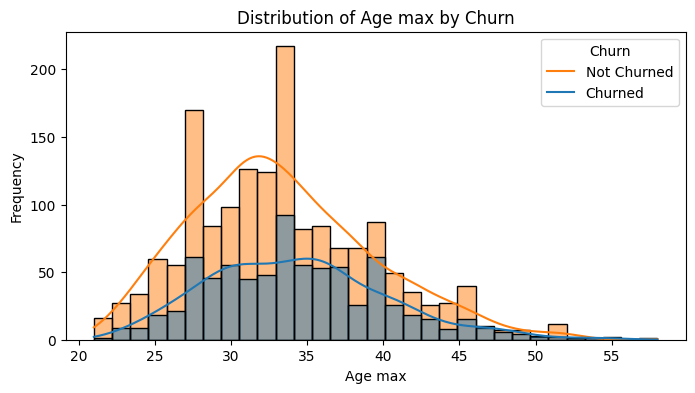

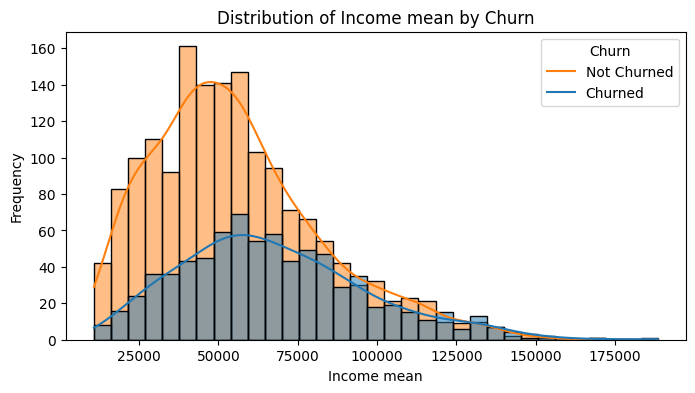

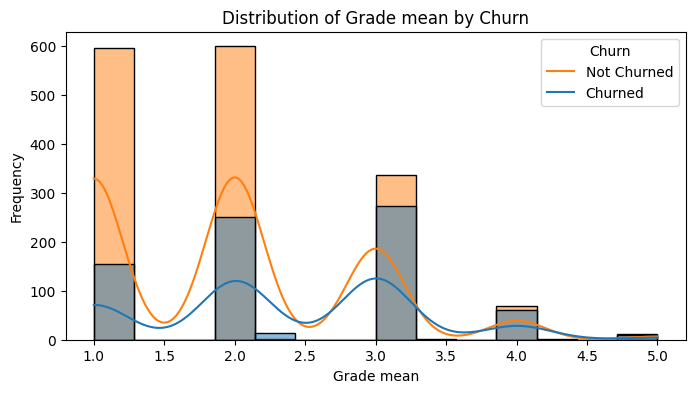

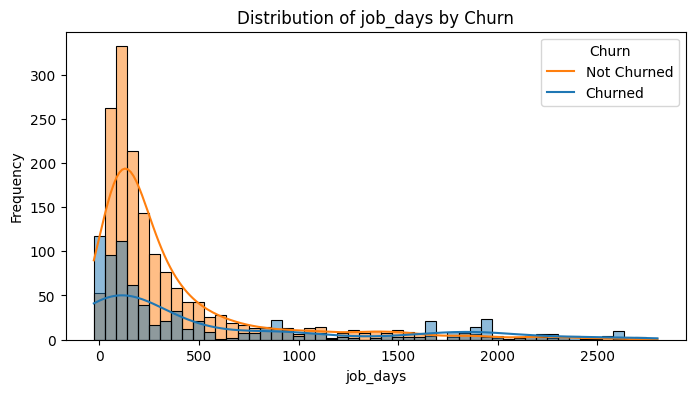

In [239]:
# Univariate Analysis (Continuous Variables)
continuous_vars = ['Age max', 'Income mean', 'Grade mean', 'job_days']
for col in continuous_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df_final, x=col, kde=True, hue='Churn max')
    plt.title(f'Distribution of {col} by Churn')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend(title='Churn', labels=['Not Churned', 'Churned'])
    plt.show()



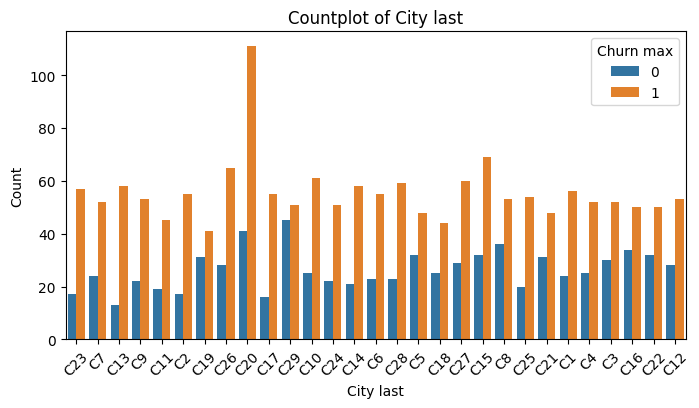

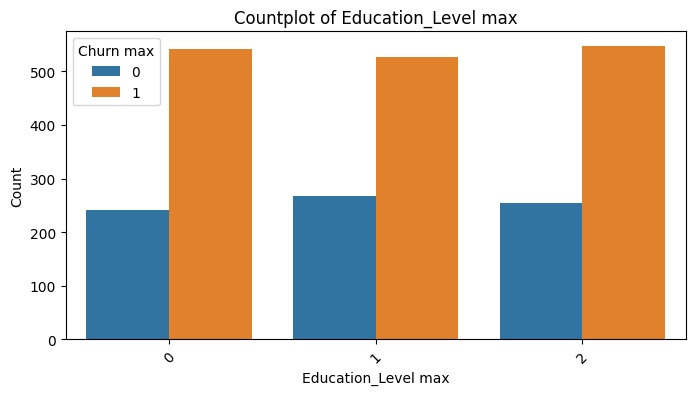

In [196]:
# Univariate Analysis (Categorical Variables)
categorical_vars = ['City last', 'Education_Level max']
for col in categorical_vars:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df_final, x=col, hue='Churn max')
    plt.title(f'Countplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()




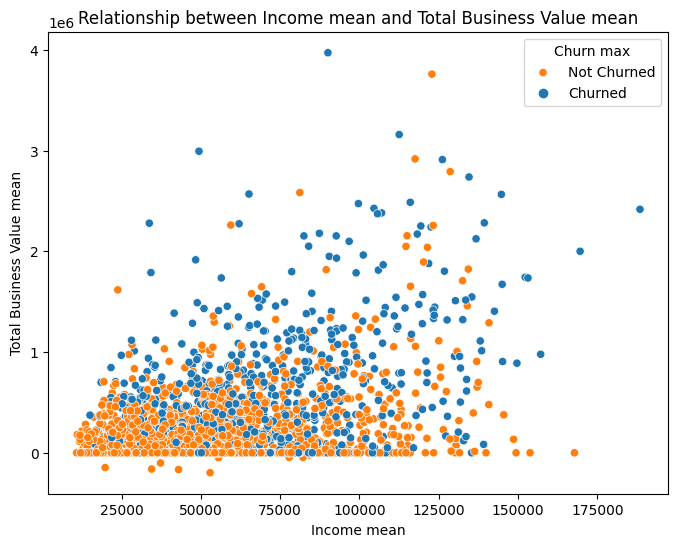

In [197]:
# Bivariate Analysis (Relationships between important variables)
# Relationship between 'Income mean' and 'Total Business Value mean'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_final, x='Income mean', y='Total Business Value mean', hue='Churn max')
plt.title('Relationship between Income mean and Total Business Value mean')
plt.xlabel('Income mean')
plt.ylabel('Total Business Value mean')
plt.legend(title='Churn max', loc='upper right', labels=['Not Churned', 'Churned'])
plt.show()


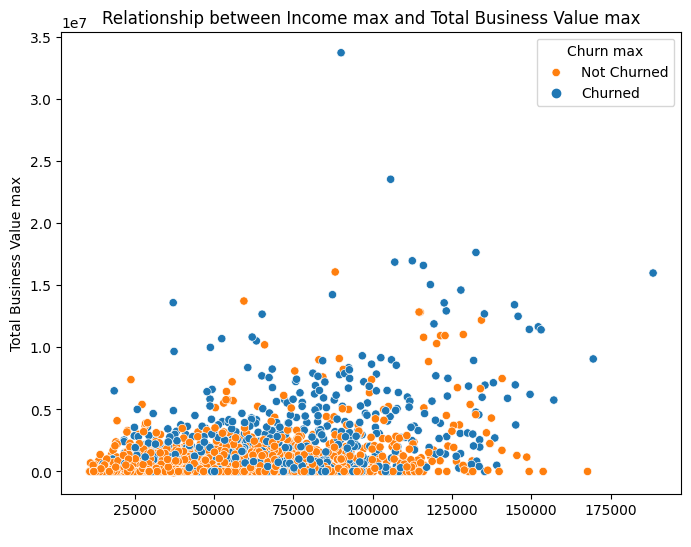

In [241]:
# Bivariate Analysis (Relationships between important variables)
# Relationship between 'Income sum' and 'Total Business Value sum'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_final, x='Income max', y='Total Business Value max', hue='Churn max')
plt.title('Relationship between Income max and Total Business Value max')
plt.xlabel('Income max')
plt.ylabel('Total Business Value max')
plt.legend(title='Churn max', loc='upper right', labels=['Not Churned', 'Churned'])
plt.show()


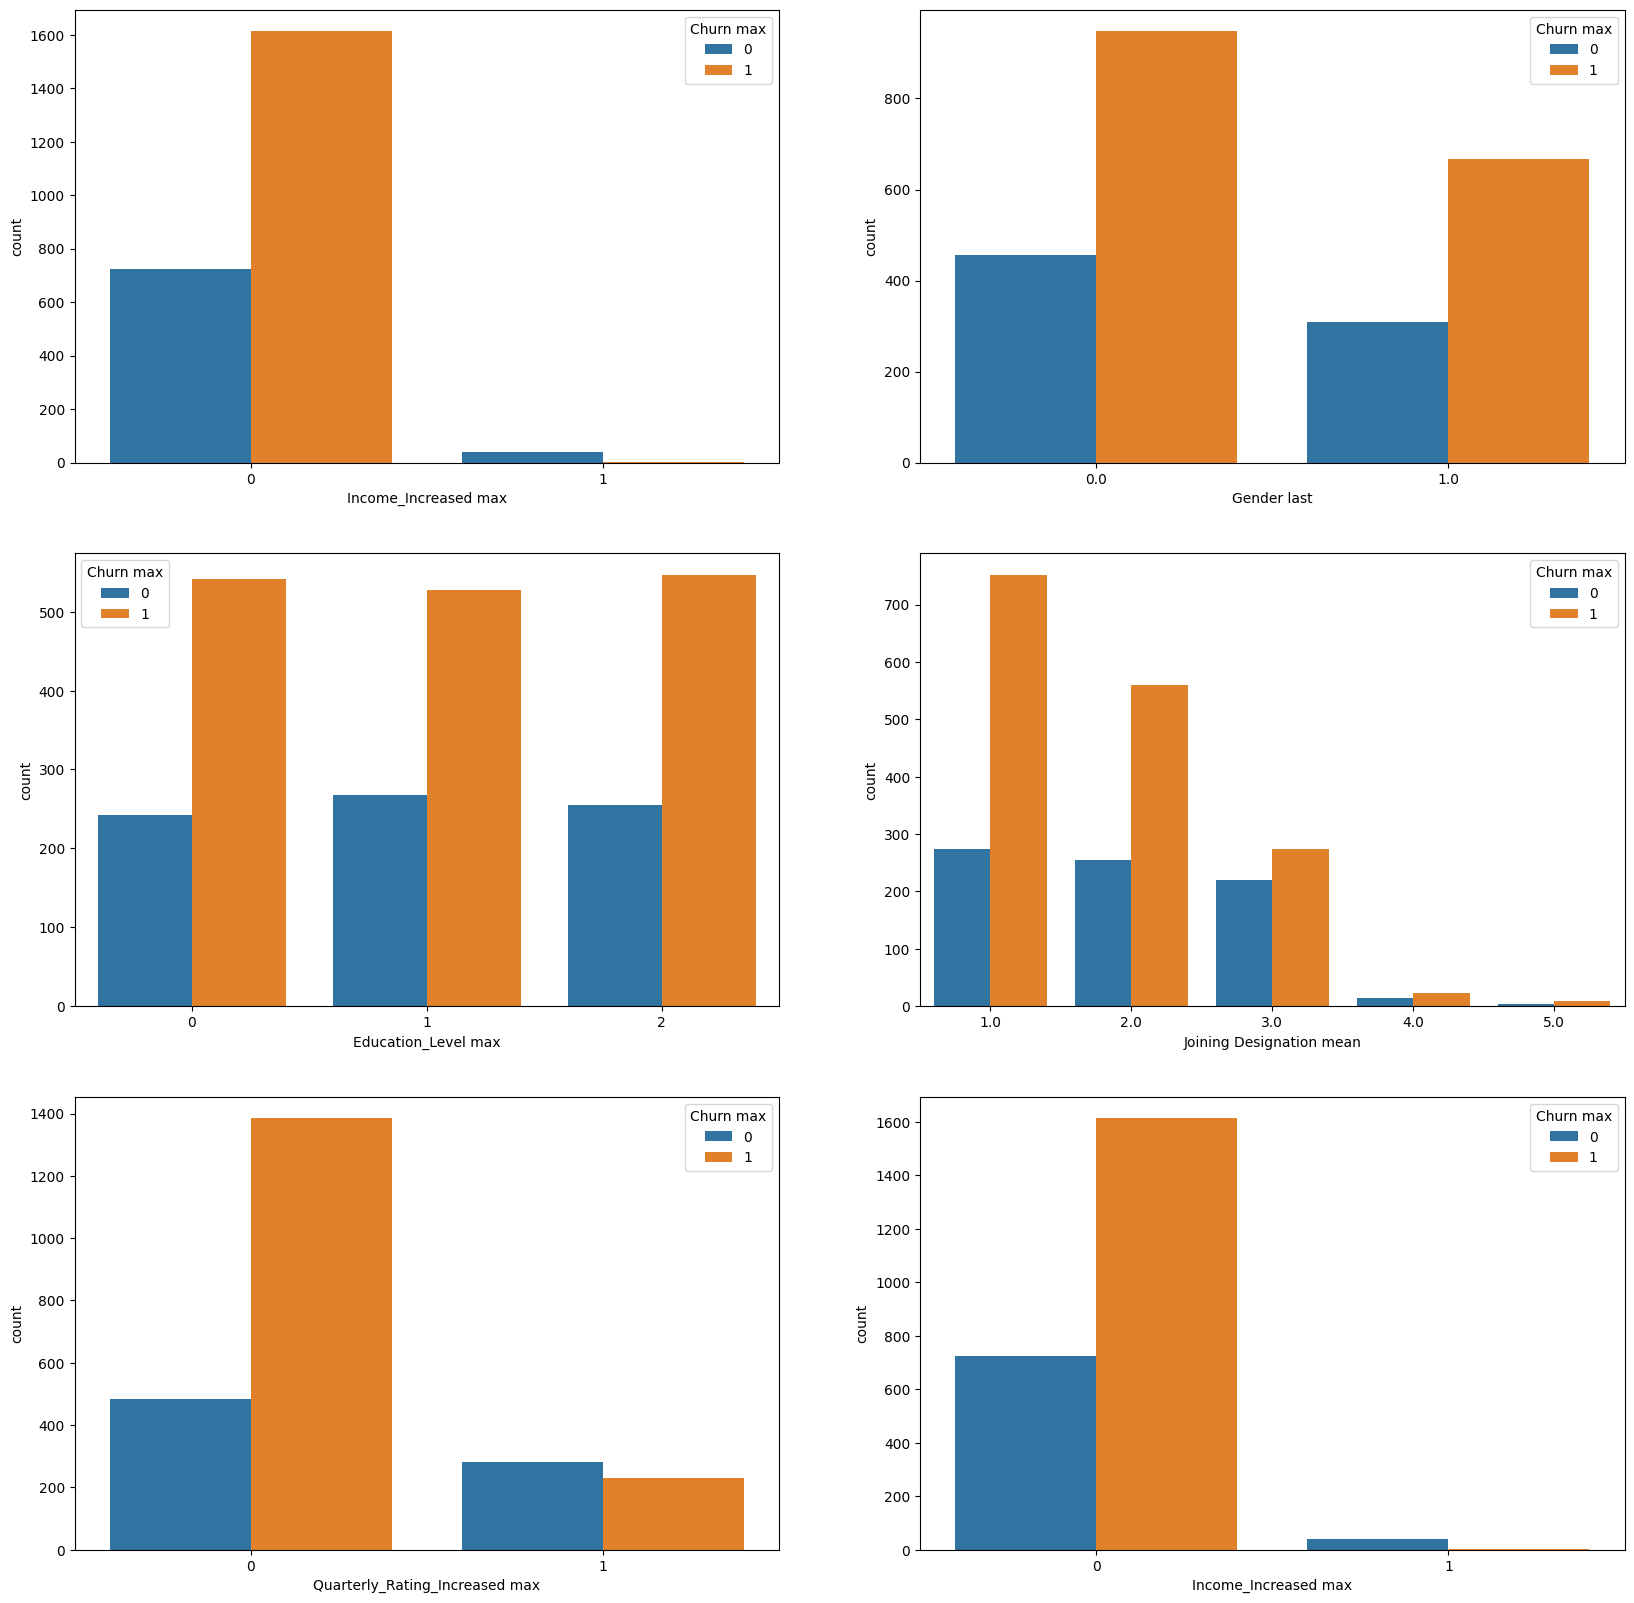

In [36]:
features = ['Income_Increased max', 'Gender last', 'Education_Level max', 'Joining Designation mean', 'Quarterly_Rating_Increased max', 'Income_Increased max']

fig, axs = plt.subplots(3, 2, figsize = (20, 20))
for i, ax in zip(features, axs.ravel()):
  sns.countplot(data = df_final, x = i, hue = 'Churn max', ax = ax)

<Axes: xlabel='City last', ylabel='count'>

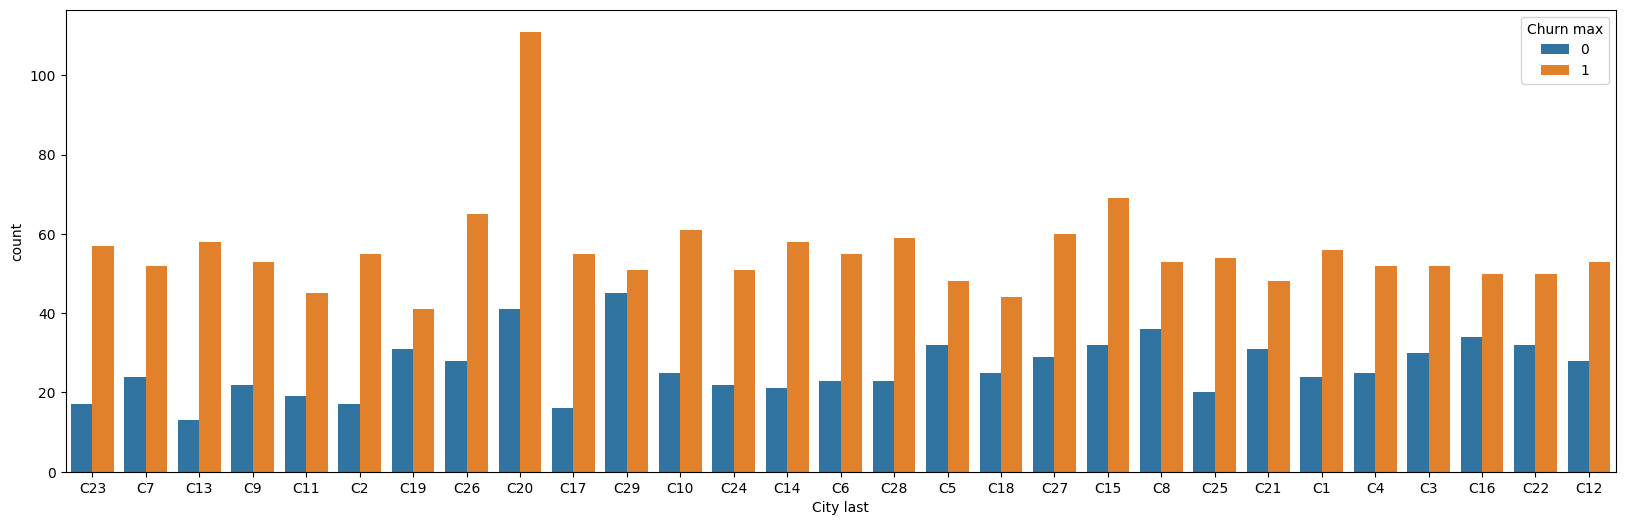

In [37]:
plt.figure(figsize = (20, 6))
sns.countplot(data = df_final, x = 'City last', hue = 'Churn max')

## Data Insights from above graphs
* Churn customers are more in dataset, nearly twice the non churned customers.
* Ages are majorly from 25 to 40. Age 35+ years are more likely to Churn.
* mostly drivers have income 25000 to 100000. From incomes > 75000, churn customers are seen in more percentage
* we see much more churned customers after 2 years (700 days)
* ratio of male to female drivers is 60:40
* more income & less business value also increases chances of Churn
* quarterly ratings & income is increased recently for Churn customers
* joining designation 1 is more prone to Churn while joining designation 3 retains the drivers more.
* Cities like C20 & C17 have concerning churn rates. Ola should try to retain drivers here.
* High business value drivers have mostly churned which is concerning. Income should be increased proportionately for them.


In [72]:
# we notice c20 & c17 city ids have high churn rate %
# lets encode city to target variable churn

city_churn_means = df_final.groupby('City last')['Churn max'].mean().reset_index()
df = df_final.merge(city_churn_means, on='City last', how='left')
df.rename(columns={'Churn max_x': 'Churn', 'Churn max_y': 'city_encoded'}, inplace=True)
df.drop(['City last','Driver_ID'], axis=1, inplace=True)
df

,dt len,Age max,Gender last,Education_Level max,Income mean,Income max,Income_Increased sum,Income_Increased max,Joining Designation min,Joining Designation max,Grade mean,Grade max,Grade min,Total Business Value sum,Total Business Value mean,Total Business Value std,Quarterly Rating mean,Quarterly Rating max,Quarterly Rating min,Quarterly_Rating_Increased sum,Quarterly_Rating_Increased max,Churn,job_days,city_encoded
0,3,28.0,0.0,2,57387.0,57387,0,0,1,1,1.0,1,1,1715580,571860.000000,1.601755e+06,2.000000,2,2,0,0,1,77.0,0.770270
1,2,31.0,0.0,2,67016.0,67016,0,0,2,2,2.0,2,2,0,0.000000,0.000000e+00,1.000000,1,1,0,0,0,25.0,0.684211
2,5,43.0,0.0,2,65603.0,65603,0,0,2,2,2.0,2,2,350000,70000.000000,1.565248e+05,1.000000,1,1,0,0,1,142.0,0.816901
3,3,29.0,0.0,0,46368.0,46368,0,0,1,1,1.0,1,1,120360,40120.000000,6.948988e+04,1.000000,1,1,0,0,1,57.0,0.706667
4,5,31.0,1.0,1,78728.0,78728,0,0,3,3,3.0,3,3,1265000,253000.000000,5.657252e+05,1.600000,2,1,5,1,0,123.0,0.703125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,24,34.0,0.0,0,82815.0,82815,0,0,2,2,3.0,3,3,21748820,906200.833333,1.246169e+06,2.625000,4,1,24,1,0,1874.0,0.698630
2377,3,34.0,1.0,0,12105.0,12105,0,0,1,1,1.0,1,1,0,0.000000,0.000000e+00,1.000000,1,1,0,0,1,61.0,0.706667
2378,9,45.0,0.0,0,35370.0,35370,0,0,2,2,2.0,2,2,2815090,312787.777778,3.130502e+05,1.666667,2,1,0,0,1,418.0,0.569444
2379,6,28.0,1.0,2,69498.0,69498,0,0,1,1,1.0,1,1,977830,162971.666667,1.854252e+05,1.500000,2,1,0,0,1,334.0,0.730263


<Axes: >

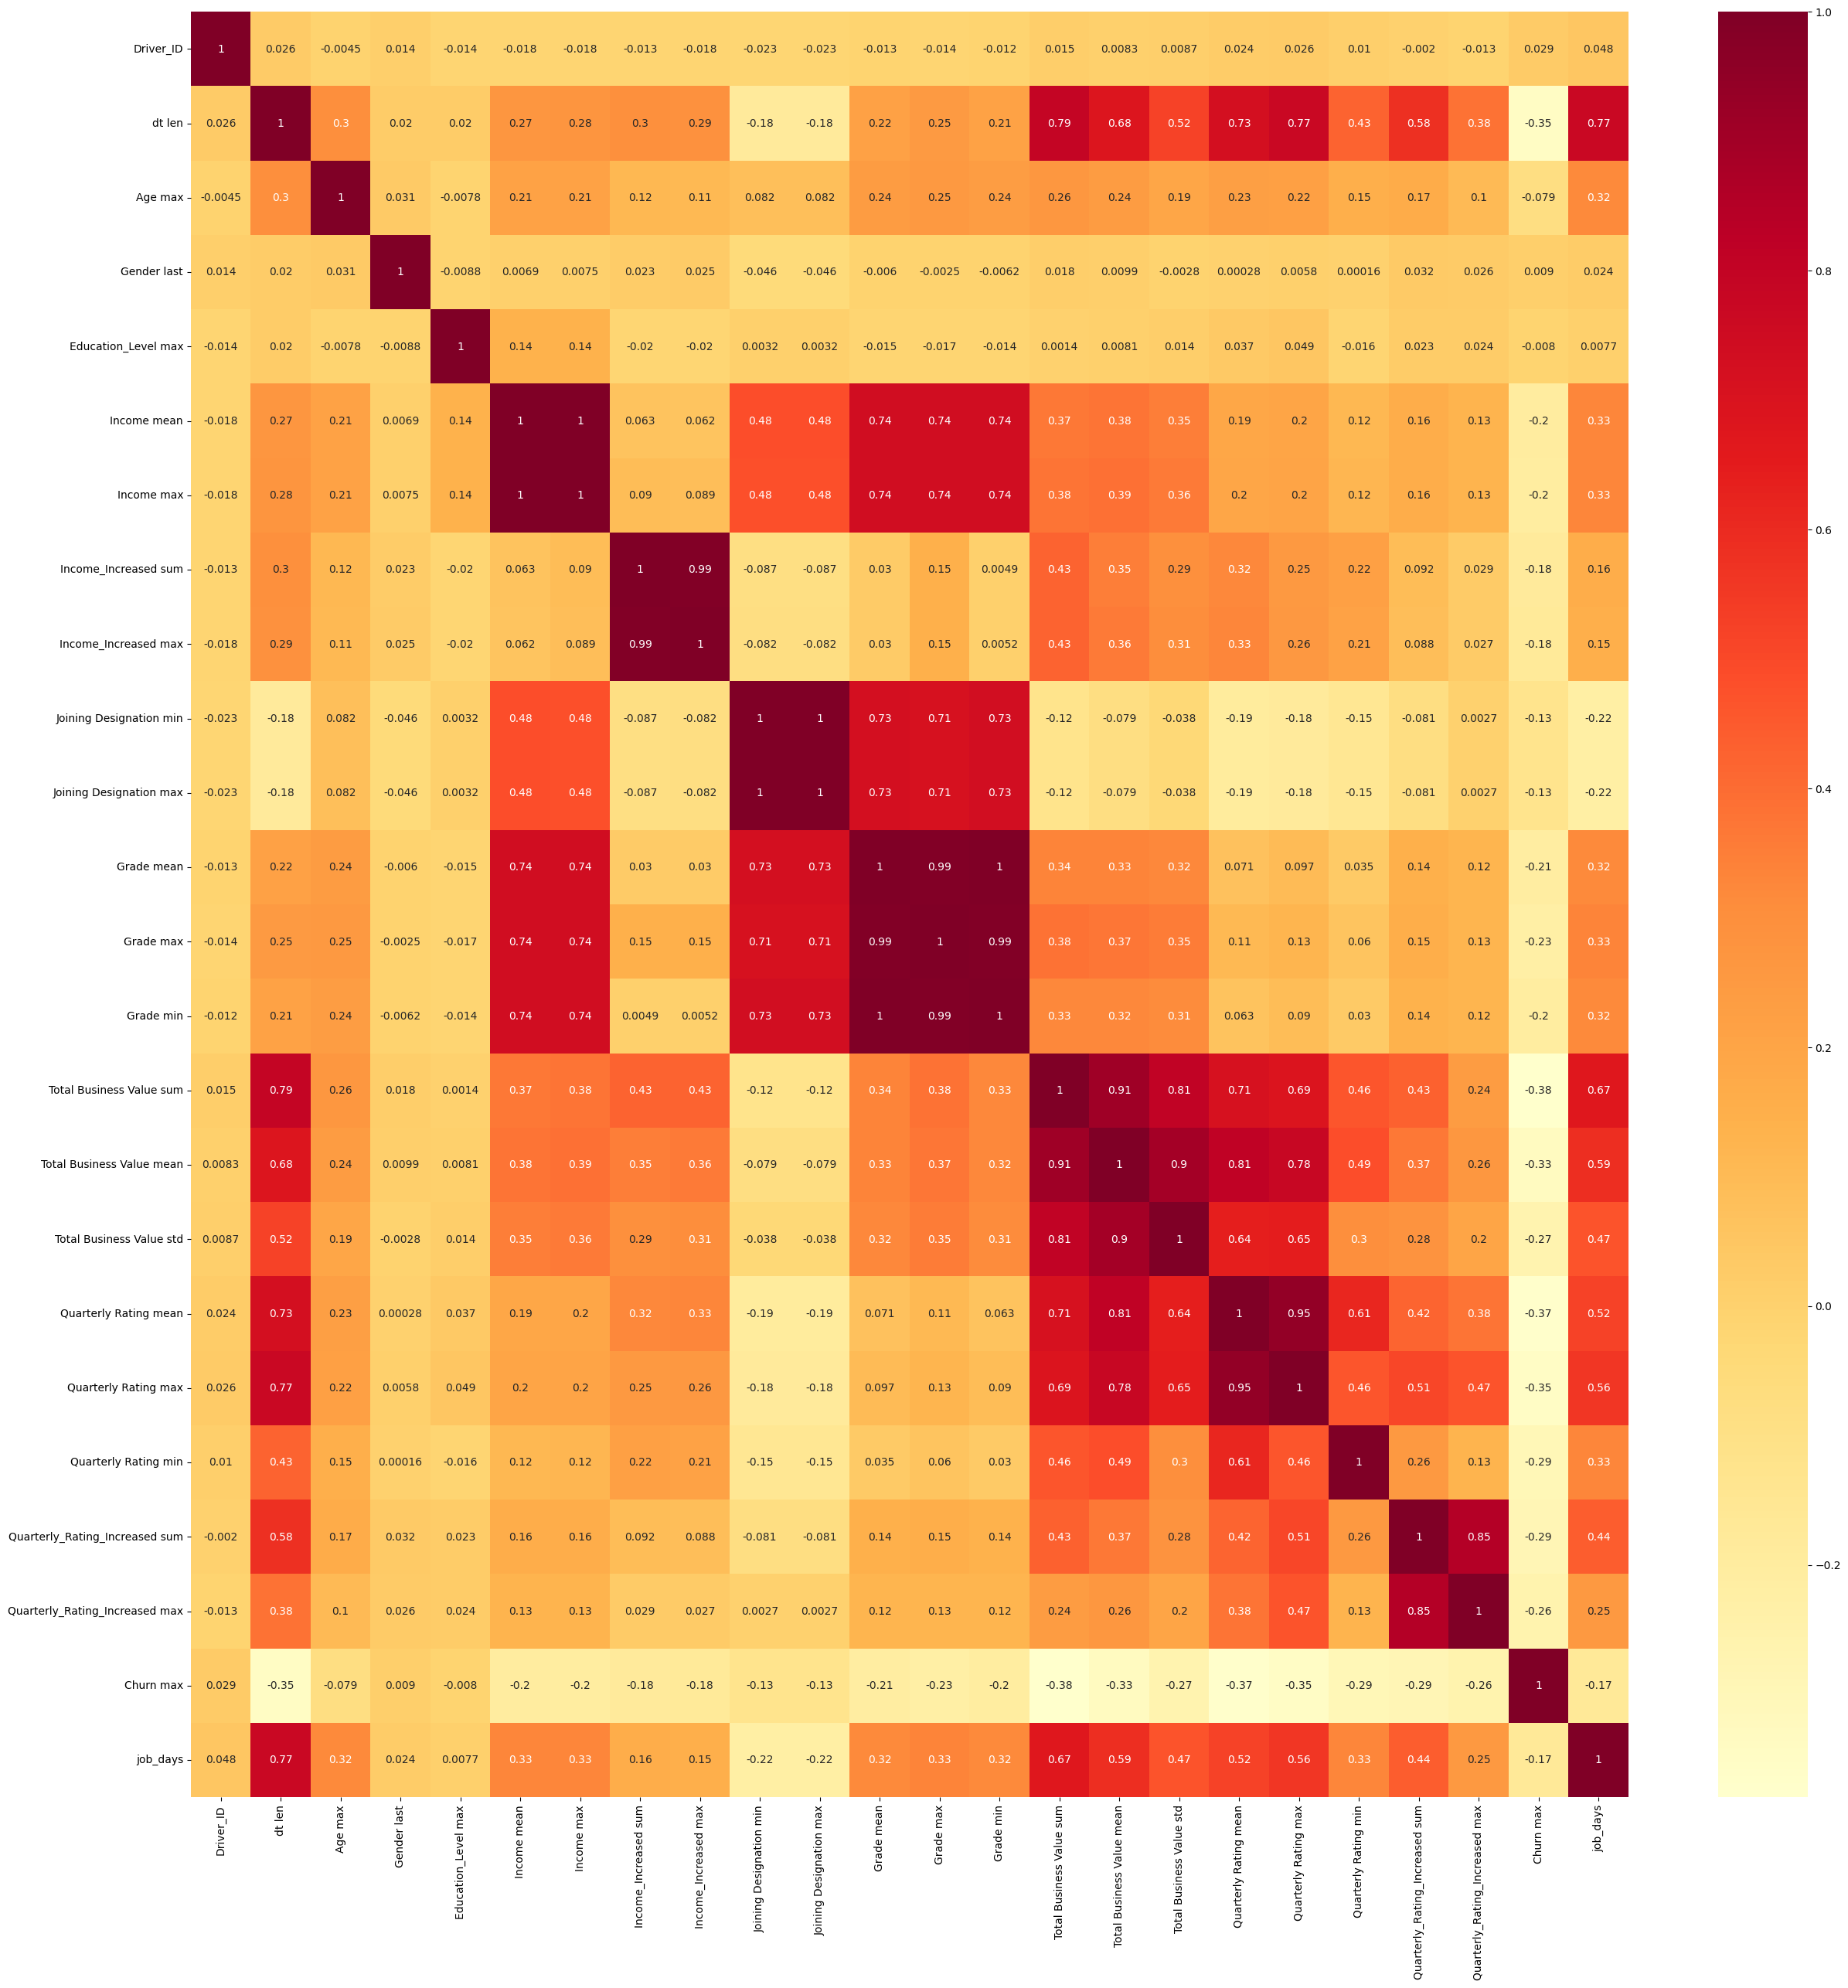

In [190]:
plt.figure(figsize=(30, 30))
sns.heatmap(df_final.corr(), annot = True, cmap = "YlOrRd", annot_kws = {"size": 10})

In [74]:
# all are numerical features now
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2381 entries, 0 to 2380
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   dt len                          2381 non-null   int64  
 1   Age max                         2381 non-null   float64
 2   Gender last                     2381 non-null   float64
 3   Education_Level max             2381 non-null   int64  
 4   Income mean                     2381 non-null   float64
 5   Income max                      2381 non-null   int64  
 6   Income_Increased sum            2381 non-null   int64  
 7   Income_Increased max            2381 non-null   int64  
 8   Joining Designation min         2381 non-null   int64  
 9   Joining Designation max         2381 non-null   int64  
 10  Grade mean                      2381 non-null   float64
 11  Grade max                       2381 non-null   int64  
 12  Grade min                       23

# Data Preprocessing
* KNN Imputation - done on Total Business Value std	later in notebook
* Feature Engineering - derived many features from aggregated driver data
* Class Imbalance treatment - used SMOT & algorith level hyperparameter (scale_pos_weight)
* Standardization - done as preprocessing to get X & y features
* Encoding - Target encoding done on city

In [79]:
X = df.drop(columns = ['Churn'], axis = 1)
y = df['Churn']

Multicollinearity check using Variance Inflation Factor (VIF) -

Multicollinearity occurs when two or more independent variables are highly correlated with one another in a regression model. Multicollinearity can be a problem in a regression model because we would not be able to distinguish between the individual effects of the independent variables on the dependent variable.

Multicollinearity can be detected via various methods. One such method is Variance Inflation Factor aka VIF.
In VIF method, we pick each independent feature and regress it against all of the other independent features.
VIF score of an independent variable represents how well the variable is explained by other independent variables.

VIF = 1/1-R2

In [80]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
    # Calculating the VIF
    vif = pd.DataFrame()
    vif['Feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by='VIF', ascending = False)
    return vif

calc_vif(X)[:5]

,Feature,VIF
11,Grade max,inf
12,Grade min,inf
7,Income_Increased max,inf
8,Joining Designation min,inf
9,Joining Designation max,inf


In [81]:
X.drop(columns=['Grade min'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
8,Joining Designation min,inf
9,Joining Designation max,inf
5,Income max,88662.23
4,Income mean,88493.33
11,Grade max,30454.20


In [82]:
X.drop(columns=['Joining Designation max'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
5,Income max,88662.23
4,Income mean,88493.33
10,Grade max,30454.20
9,Grade mean,30059.25
7,Income_Increased max,139.63


In [83]:
X.drop(columns=['Income max'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
9,Grade max,30322.10
8,Grade mean,29930.63
6,Income_Increased max,135.60
13,Quarterly Rating mean,125.47
14,Quarterly Rating max,73.81


In [84]:
X.drop(columns=['Grade max'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
12,Quarterly Rating mean,125.27
13,Quarterly Rating max,73.75
5,Income_Increased sum,53.60
6,Income_Increased max,53.59
8,Grade mean,43.35


In [86]:
X.drop(columns=['Quarterly Rating mean'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
5,Income_Increased sum,53.59
6,Income_Increased max,53.46
8,Grade mean,42.10
17,city_encoded,35.80
1,Age max,32.17


In [87]:
X.drop(columns=['Income_Increased sum'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
7,Grade mean,42.07
16,city_encoded,35.74
1,Age max,32.17
6,Joining Designation min,27.25
9,Total Business Value mean,25.54


In [88]:
X.drop(columns=['Grade mean'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
15,city_encoded,35.45
1,Age max,31.98
8,Total Business Value mean,25.22
10,Quarterly Rating max,23.43
0,dt len,18.08


In [89]:
X.drop(columns=['city_encoded'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
8,Total Business Value mean,24.00
10,Quarterly Rating max,22.69
1,Age max,18.93
0,dt len,18.06
7,Total Business Value sum,16.29


In [90]:
X.drop(columns=['Total Business Value mean'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
9,Quarterly Rating max,17.77
1,Age max,17.65
0,dt len,16.97
10,Quarterly Rating min,11.08
4,Income mean,10.68


In [91]:
X.drop(columns=['Quarterly Rating max'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
1,Age max,17.43
0,dt len,11.17
4,Income mean,10.62
6,Joining Designation min,9.62
9,Quarterly Rating min,9.57


In [92]:
X.drop(columns=['Age max'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
3,Income mean,10.54
0,dt len,10.41
6,Total Business Value sum,8.36
5,Joining Designation min,8.26
8,Quarterly Rating min,6.44


In [143]:
X.drop(columns=['Income mean'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
0,dt len,10.37
5,Total Business Value sum,8.26
7,Quarterly Rating min,6.35
8,Quarterly_Rating_Increased sum,6.22
9,Quarterly_Rating_Increased max,5.29


In [145]:
X.drop(columns=['Total Business Value sum'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
0,dt len,8.49
6,Quarterly Rating min,6.32
7,Quarterly_Rating_Increased sum,5.95
8,Quarterly_Rating_Increased max,5.02
9,job_days,4.11


In [146]:
X.columns

Index(['dt len', 'Gender last', 'Education_Level max', 'Income_Increased max',
       'Joining Designation min', 'Total Business Value std',
       'Quarterly Rating min', 'Quarterly_Rating_Increased sum',
       'Quarterly_Rating_Increased max', 'job_days'],
      dtype='object')

In [147]:
X.shape, y.shape

((2381, 10), (2381,))

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 5,
                                                    test_size = 0.2,
                                                    stratify = y) # stratify =y as imbalance data

In [149]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [150]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [151]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1904, 10), (1904,), (477, 10), (477,))

# Model building using:
* Logistic Regression
* Decision Tree (DT)
* Random Forest (RF)
* Random Forest with gridsearch CV for hyperparameter tuning
* Gradient Boosting DT (GBDT)
* GBDT with randomisedsearch CV for hyperparameter tuning
* LightGBM with randomisedsearch CV for hyperparameter tuning
* **Result evaluation done after each Model**

Logistic Regression

In [152]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create and train the logistic regression model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logistic_regression_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_rep)

Accuracy: 0.79
Confusion Matrix:
[[ 81  72]
 [ 29 295]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.53      0.62       153
           1       0.80      0.91      0.85       324

    accuracy                           0.79       477
   macro avg       0.77      0.72      0.73       477
weighted avg       0.78      0.79      0.78       477



Decision Tree

In [153]:
from sklearn.tree import DecisionTreeClassifier
# Create and train the Decision Tree classifier
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = decision_tree_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_rep)

Accuracy: 0.82
Confusion Matrix:
[[104  49]
 [ 35 289]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.68      0.71       153
           1       0.86      0.89      0.87       324

    accuracy                           0.82       477
   macro avg       0.80      0.79      0.79       477
weighted avg       0.82      0.82      0.82       477



Random Forest (DT gave recall of 90%, lets try RF)

In [154]:
RF = RandomForestClassifier(n_estimators = 100,
    criterion = 'entropy',
    max_depth = 20,
    min_samples_split = 3,
    min_samples_leaf = 4,
    min_weight_fraction_leaf = 0.0,
    max_features = 'sqrt',
    max_leaf_nodes = None,
    min_impurity_decrease = 0.0,
    bootstrap = True,
    oob_score = False,
    n_jobs = None,
    random_state = None,
    verbose = 0,
    warm_start = False,
    class_weight = 'balanced',
    max_samples = None)

In [155]:
RF.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, min_samples_leaf=4, min_samples_split=3)

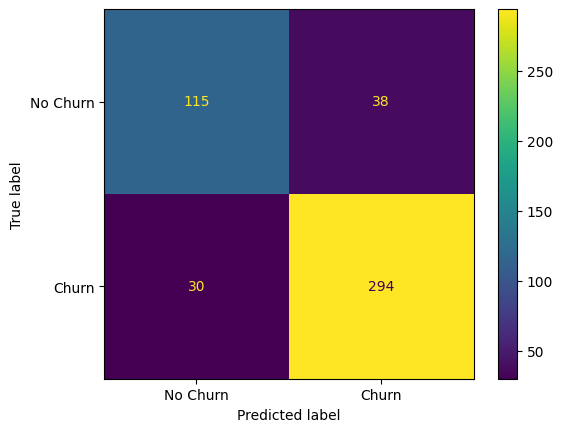

In [156]:
y_pred = RF.predict(X_test)
y_pred_train = RF.predict(X_train)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels = ['No Churn', 'Churn']).plot()

In [157]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       612
           1       0.95      0.94      0.94      1292

    accuracy                           0.92      1904
   macro avg       0.91      0.92      0.91      1904
weighted avg       0.92      0.92      0.92      1904



In [158]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       153
           1       0.89      0.91      0.90       324

    accuracy                           0.86       477
   macro avg       0.84      0.83      0.83       477
weighted avg       0.86      0.86      0.86       477



In [159]:
train_accuracy = RF.score(X_train, y_train)
test_accuracy = RF.score(X_test, y_test)
precision_train = precision_score(y_train, y_pred_train)
precision_test = precision_score(y_test, y_pred)
recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred)
training_f1_score = f1_score(y_train, y_pred_train)
test_f1_score = f1_score(y_test, y_pred)

training_data_metrics = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1-Score'], data = [train_accuracy, precision_train, recall_train, training_f1_score], columns = ['Values']).reset_index()
training_data_metrics.rename(columns = {'index': 'Training Data Metrics'}, inplace = True)
test_data_metrics = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1-Score'], data = [test_accuracy, precision_test, recall_test, test_f1_score], columns = ['Values']).reset_index()
test_data_metrics.rename(columns = {'index': 'Test Data Metrics'}, inplace = True)

In [160]:
training_data_metrics

,Training Data Metrics,Values
0,Accuracy,0.923845
1,Precision,0.950511
2,Recall,0.936533
3,F1-Score,0.943470


In [161]:
test_data_metrics

,Test Data Metrics,Values
0,Accuracy,0.857442
1,Precision,0.885542
2,Recall,0.907407
3,F1-Score,0.896341


<Axes: >

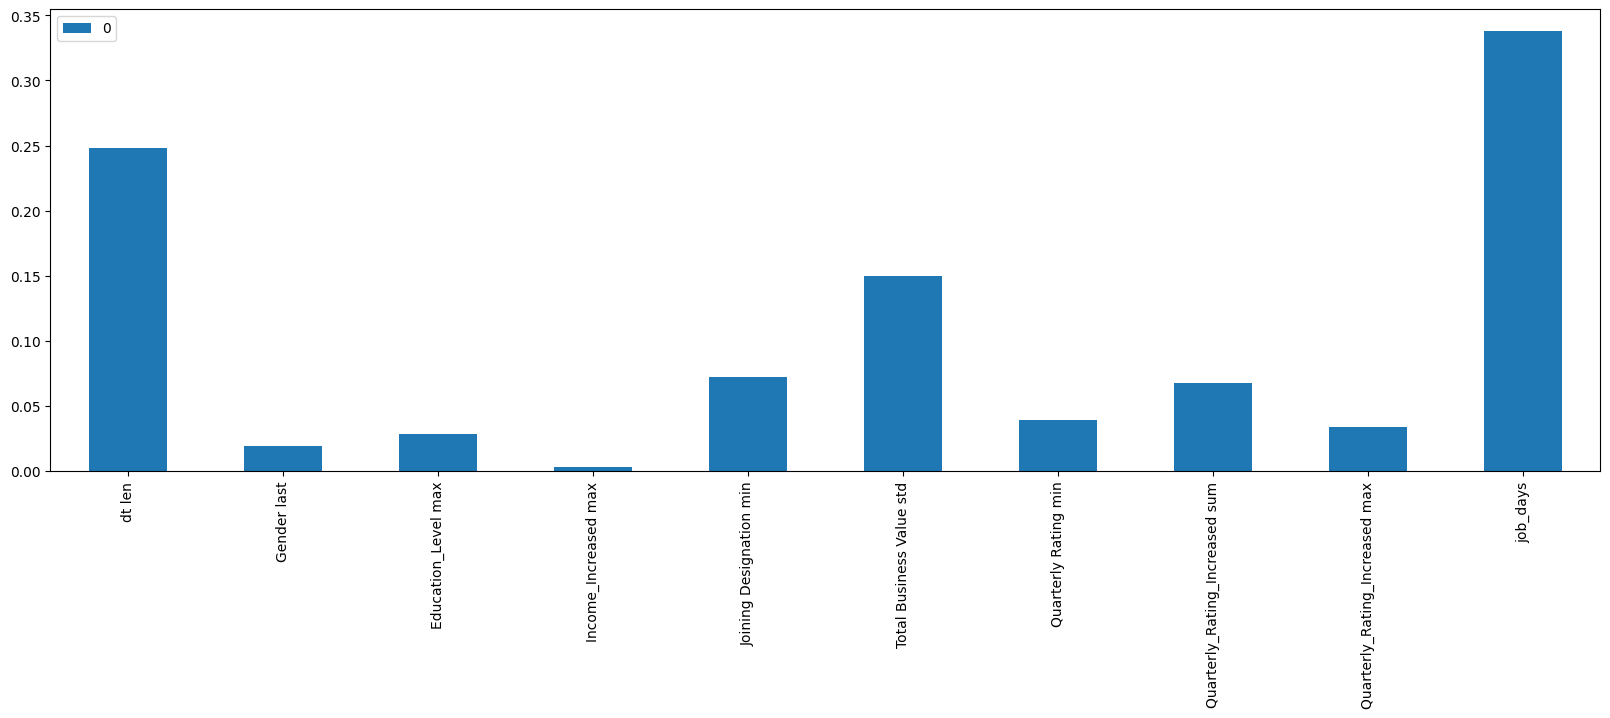

In [162]:
# feature importance
pd.DataFrame(data = RF.feature_importances_,
            index = X.columns).plot(kind = "bar", figsize = (20, 6))

Oversample Churn data & use RF

> we have decent recall of ~92% using RF, lets try using smote




In [163]:
from imblearn.over_sampling import SMOTE

smoteBalance = SMOTE(k_neighbors = 7)
X_smote, y_smote = smoteBalance.fit_resample(X_train, y_train)
X_smote.shape, y_smote.shape

((2584, 10), (2584,))

In [164]:
RF.fit(X_smote, y_smote)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, min_samples_leaf=4, min_samples_split=3)

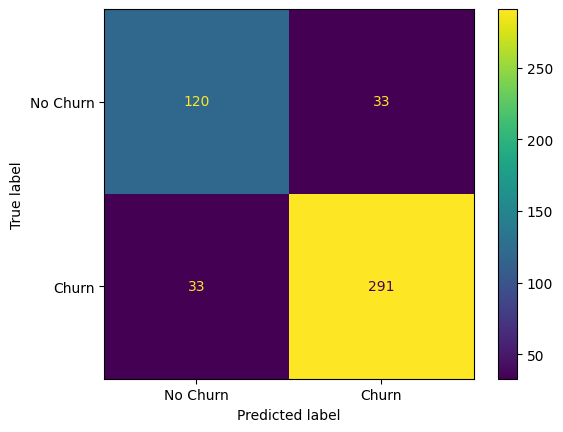

In [165]:
y_train_pred_bal = RF.predict(X_smote)
y_pred_bal = RF.predict(X_test)

cm = confusion_matrix(y_test, y_pred_bal)

ConfusionMatrixDisplay(cm, display_labels = ['No Churn', 'Churn']).plot()

In [112]:
train_accuracy = RF.score(X_smote, y_smote)
test_accuracy = RF.score(X_test, y_test)
precision_train = precision_score(y_smote, y_train_pred_bal)
precision_test = precision_score(y_test, y_pred_bal)
recall_train = recall_score(y_smote, y_train_pred_bal)
recall_test = recall_score(y_test, y_pred_bal)
training_f1_score = f1_score(y_smote, y_train_pred_bal)
test_f1_score = f1_score(y_test, y_pred_bal)

training_data_metrics = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1-Score'], data = [train_accuracy, precision_train, recall_train, training_f1_score], columns = ['Values']).reset_index()
training_data_metrics.rename(columns = {'index': 'Training Data Metrics'}, inplace = True)
test_data_metrics = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1-Score'], data = [test_accuracy, precision_test, recall_test, test_f1_score], columns = ['Values']).reset_index()
test_data_metrics.rename(columns = {'index': 'Test Data Metrics'}, inplace = True)

In [113]:
training_data_metrics

,Training Data Metrics,Values
0,Accuracy,0.946981
1,Precision,0.937169
2,Recall,0.958204
3,F1-Score,0.947570


In [114]:
test_data_metrics

,Test Data Metrics,Values
0,Accuracy,0.865828
1,Precision,0.898773
2,Recall,0.904321
3,F1-Score,0.901538


Apply Grid search & use RF on smote data

In [121]:
from sklearn.model_selection import GridSearchCV

parameters = {"max_depth":[7, 10, 15, 20, 25, 30],
             "n_estimators":[50, 100, 200, 300, 400],
             "max_features":[4, 7, 10],
             "ccp_alpha":[0.0005, 0.00075, 0.001]}

RFC = RandomForestClassifier()
grid_search = GridSearchCV(
    estimator = RFC,
    param_grid = parameters,
    scoring = "accuracy",
    n_jobs = -1,
    refit=True,                   # need not to train again after grid search
    cv=3,
    pre_dispatch='2*n_jobs',
    return_train_score=False)

In [122]:
grid_search.fit(X_smote,y_smote.values.ravel())

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0005, 0.00075, 0.001],
                         'max_depth': [7, 10, 15], 'max_features': [4, 7, 10],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='accuracy')

In [123]:
grid_search.best_estimator_

RandomForestClassifier(ccp_alpha=0.0005, max_depth=15, max_features=7,
                       n_estimators=200)

In [124]:
grid_search.best_score_

0.8773373646895236

In [125]:
grid_search.best_params_

{'ccp_alpha': 0.0005, 'max_depth': 15, 'max_features': 7, 'n_estimators': 200}

In [128]:
RF_best_params = RandomForestClassifier(n_estimators = 300,
    criterion = 'entropy',
    max_depth = 15,
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_features = 10,
    class_weight = "balanced",
    ccp_alpha = 0.001,
    max_samples = None)

In [130]:
RF_best_params.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.001, class_weight='balanced',
                       criterion='entropy', max_depth=15, max_features=10,
                       n_estimators=300)

In [139]:
def roc_curve_plot(y_test, pred_prob, model_name):
  logit_roc_auc = roc_auc_score(y_test, pred_prob)
  fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
  plt.figure()
  plt.plot(fpr, tpr, label= model_name + ' (Area under ROC = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.savefig('ROC_for_' + model_name)
  plt.show()

def precision_recall_curve_plot(y_test, pred_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_prob)
    prec_rec_auc = np.round(auc(recalls, precisions), 2)

    threshold_boundary = thresholds.shape[0]

    #Precision Plot
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label = 'Precisions')

    #Recall Plot
    plt.plot(thresholds, recalls[0:threshold_boundary], label='Recalls')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold Value')
    plt.ylabel('Precision and Recall Value')
    plt.title(f'Precision recall curve with AUC : {prec_rec_auc}')
    plt.legend()
    plt.grid()
    plt.show()

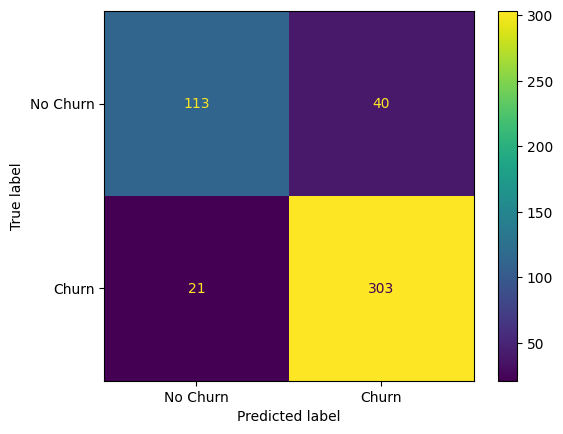

In [131]:
y_pred = RF_best_params.predict(X_test)
y_pred_train = RF_best_params.predict(X_train)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm, display_labels = ['No Churn', 'Churn']).plot()

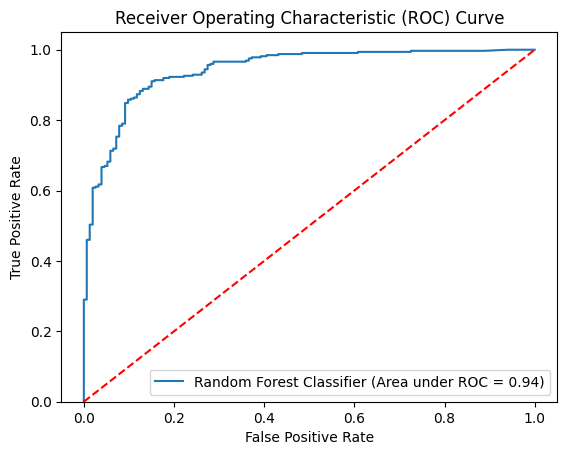

In [132]:
roc_curve_plot(y_test, RF_best_params.predict_proba(X_test)[:, 1], 'Random Forest Classifier')

In [133]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       612
           1       1.00      1.00      1.00      1292

    accuracy                           1.00      1904
   macro avg       1.00      1.00      1.00      1904
weighted avg       1.00      1.00      1.00      1904



In [134]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79       153
           1       0.88      0.94      0.91       324

    accuracy                           0.87       477
   macro avg       0.86      0.84      0.85       477
weighted avg       0.87      0.87      0.87       477



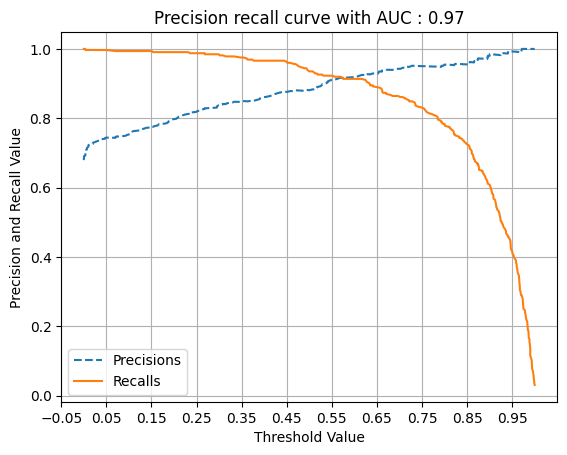

In [135]:
precision_recall_curve_plot(y_test, RF_best_params.predict_proba(X_test)[:, 1])

Gradient Boosting

In [166]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier()
gbt.fit(X_train, y_train)

GradientBoostingClassifier()

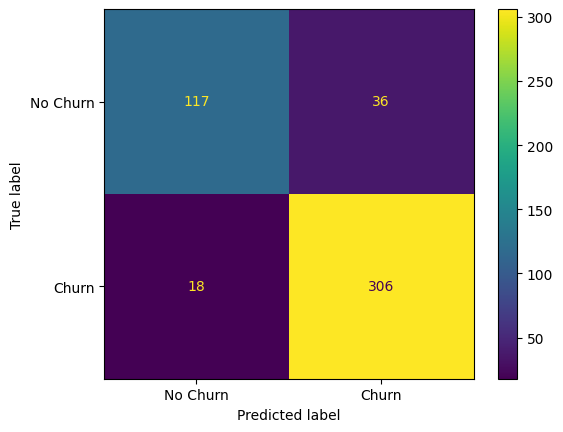

In [167]:
y_pred = gbt.predict(X_test)
y_pred_train = gbt.predict(X_train)
prob = gbt.predict_proba(X_test)
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm, display_labels = ['No Churn', 'Churn']).plot()

In [168]:
train_accuracy = gbt.score(X_train, y_train)
test_accuracy = gbt.score(X_test, y_test)
precision_train = precision_score(y_train, y_pred_train)
precision_test = precision_score(y_test, y_pred)
recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred)
training_f1_score = f1_score(y_train, y_pred_train)
test_f1_score = f1_score(y_test, y_pred)

training_data_metrics = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1-Score'], data = [train_accuracy, precision_train, recall_train, training_f1_score], columns = ['Values']).reset_index()
training_data_metrics.rename(columns = {'index': 'Training Data Metrics'}, inplace = True)
test_data_metrics = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1-Score'], data = [test_accuracy, precision_test, recall_test, test_f1_score], columns = ['Values']).reset_index()
test_data_metrics.rename(columns = {'index': 'Test Data Metrics'}, inplace = True)

In [169]:
training_data_metrics

,Training Data Metrics,Values
0,Accuracy,0.904937
1,Precision,0.904588
2,Recall,0.961300
3,F1-Score,0.932083


In [170]:
test_data_metrics

,Test Data Metrics,Values
0,Accuracy,0.886792
1,Precision,0.894737
2,Recall,0.944444
3,F1-Score,0.918919


gbdt grid search

In [141]:
parameters = {"max_depth":[7, 10, 15],
             "n_estimators":[100, 200, 300, 400],
             "max_features":[4, 7, 10],
             "ccp_alpha":[0.0005, 0.00075, 0.001]}

gbt = GradientBoostingClassifier()
grid_search = GridSearchCV(
    estimator = gbt,
    param_grid = parameters,
    scoring = "accuracy",
    n_jobs = -1,
    refit=True,                   # need not to train again after grid search
    cv=3,
    pre_dispatch='2*n_jobs',
    return_train_score=False)

In [142]:
grid_search.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0005, 0.00075, 0.001],
                         'max_depth': [7, 10, 15], 'max_features': [4, 7, 10],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='accuracy')

In [143]:
grid_search.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0005, max_depth=7, max_features=7,
                           n_estimators=200)

In [144]:
grid_search.best_score_

0.8666062246950993

In [145]:
grid_search.best_params_

{'ccp_alpha': 0.0005, 'max_depth': 7, 'max_features': 7, 'n_estimators': 200}

In [146]:
gbt = GradientBoostingClassifier(ccp_alpha = 0.0005,
                                 max_depth= 7,
                                 max_features = 10,
                                 n_estimators = 200)
gbt.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0005, max_depth=7, max_features=10,
                           n_estimators=200)

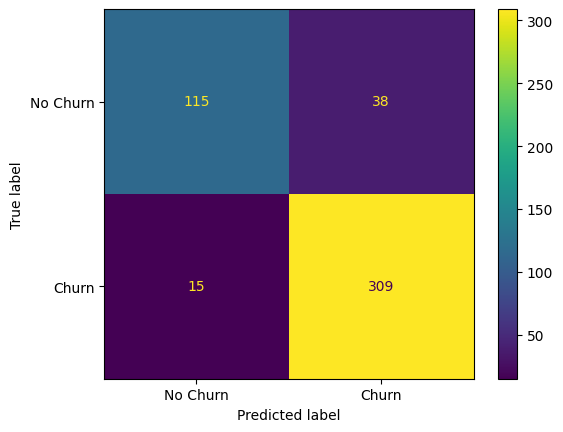

In [147]:
y_pred = gbt.predict(X_test)
y_pred_train = gbt.predict(X_train)
prob = gbt.predict_proba(X_test)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm, display_labels = ['No Churn', 'Churn']).plot()

In [148]:
train_accuracy = gbt.score(X_train, y_train)
test_accuracy = gbt.score(X_test, y_test)
precision_train = precision_score(y_train, y_pred_train)
precision_test = precision_score(y_test, y_pred)
recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred)
training_f1_score = f1_score(y_train, y_pred_train)
test_f1_score = f1_score(y_test, y_pred)

training_data_metrics = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1-Score'], data = [train_accuracy, precision_train, recall_train, training_f1_score], columns = ['Values']).reset_index()
training_data_metrics.rename(columns = {'index': 'Training Data Metrics'}, inplace = True)
test_data_metrics = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1-Score'], data = [test_accuracy, precision_test, recall_test, test_f1_score], columns = ['Values']).reset_index()
test_data_metrics.rename(columns = {'index': 'Test Data Metrics'}, inplace = True)

In [149]:
training_data_metrics

,Training Data Metrics,Values
0,Accuracy,0.904937
1,Precision,0.897638
2,Recall,0.970588
3,F1-Score,0.932689


In [150]:
test_data_metrics

,Test Data Metrics,Values
0,Accuracy,0.888889
1,Precision,0.890490
2,Recall,0.953704
3,F1-Score,0.921013


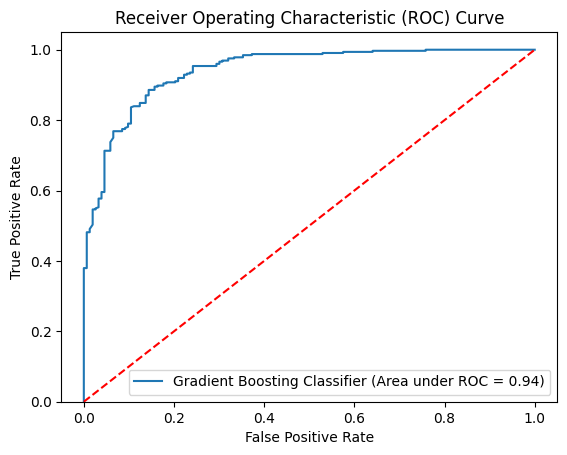

In [273]:
# AUC ROC plot
prob = gbt.predict_proba(X_test)
roc_curve_plot(y_test, prob[:, 1], 'Gradient Boosting Classifier')

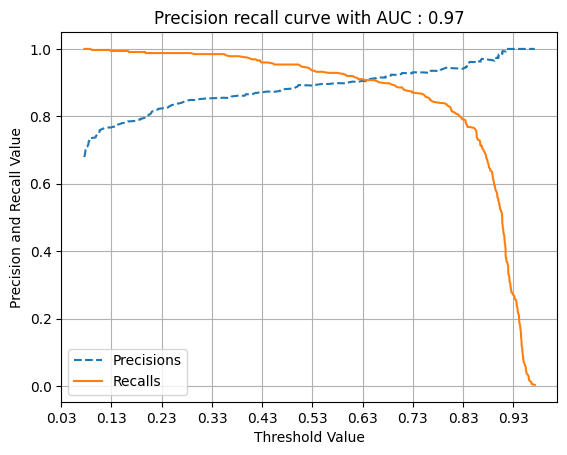

In [274]:
# precision recall plot
precision_recall_curve_plot(y_test, prob[:, 1])

xgboost classifier

In [120]:
from xgboost import XGBClassifier

In [121]:
xgb = XGBClassifier(n_estimators = 100,
                   max_depth = 5)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

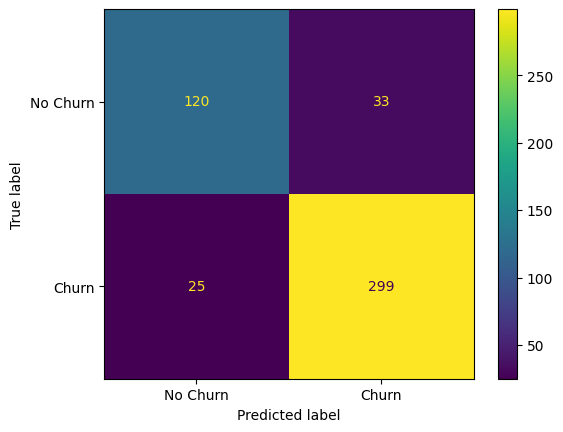

In [122]:
y_pred = xgb.predict(X_test)
y_train_pred = xgb.predict(X_train)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm, display_labels = ['No Churn', 'Churn']).plot()

In [157]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       612
           1       0.90      0.97      0.93      1292

    accuracy                           0.90      1904
   macro avg       0.91      0.87      0.89      1904
weighted avg       0.91      0.90      0.90      1904



In [158]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       153
           1       0.92      0.94      0.93       324

    accuracy                           0.91       477
   macro avg       0.90      0.89      0.89       477
weighted avg       0.90      0.91      0.91       477



In [159]:
train_accuracy = xgb.score(X_train, y_train)
test_accuracy = xgb.score(X_test, y_test)
precision_train = precision_score(y_train, y_train_pred)
precision_test = precision_score(y_test, y_pred)
recall_train = recall_score(y_train, y_train_pred)
recall_test = recall_score(y_test, y_pred)
training_f1_score = f1_score(y_train, y_train_pred)
test_f1_score = f1_score(y_test, y_pred)

training_data_metrics = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1-Score'], data = [train_accuracy, precision_train, recall_train, training_f1_score], columns = ['Values']).reset_index()
training_data_metrics.rename(columns = {'index': 'Training Data Metrics'}, inplace = True)
test_data_metrics = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1-Score'], data = [test_accuracy, precision_test, recall_test, test_f1_score], columns = ['Values']).reset_index()
test_data_metrics.rename(columns = {'index': 'Test Data Metrics'}, inplace = True)

In [160]:
training_data_metrics

,Training Data Metrics,Values
0,Accuracy,0.996849
1,Precision,0.995378
2,Recall,1.000000
3,F1-Score,0.997683


In [161]:
test_data_metrics

,Test Data Metrics,Values
0,Accuracy,0.905660
1,Precision,0.921450
2,Recall,0.941358
3,F1-Score,0.931298


xgb randomised search

In [177]:
from sklearn.model_selection import RandomizedSearchCV


# Define hyperparameter grid for random search
parameters = {"max_depth":[2, 4, 5],
             "n_estimators":[100, 200, 300, 400]}



# Create and train t with random search
xgb = XGBClassifier()
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=parameters,
    scoring="recall",
    n_iter=10,  # Number of parameter settings to sample
    n_jobs=-1,
    cv=3,
    refit=True,
    random_state=42  # Set a random seed for reproducibility
)

random_search.fit(X_train, y_train)

# Make predictions on the test data using the best model from the random search
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Best Model Parameters: {random_search.best_params_}')
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_rep)


Best Model Parameters: {'n_estimators': 100, 'max_depth': 2}
Accuracy: 0.89
Confusion Matrix:
[[120  33]
 [ 19 305]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       153
           1       0.90      0.94      0.92       324

    accuracy                           0.89       477
   macro avg       0.88      0.86      0.87       477
weighted avg       0.89      0.89      0.89       477



In [244]:
y_train.value_counts()

1    1292
0     612
Name: Churn, dtype: int64

BalancedRandomForest (since there is class imbalance)

In [217]:
from imblearn.ensemble import BalancedRandomForestClassifier

model = BalancedRandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f'Best Model Parameters: {random_search.best_params_}')
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_rep)

Best Model Parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.1}
Accuracy: 0.86
Confusion Matrix:
[[127  26]
 [ 42 282]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       153
           1       0.92      0.87      0.89       324

    accuracy                           0.86       477
   macro avg       0.83      0.85      0.84       477
weighted avg       0.86      0.86      0.86       477



LightGBM

In [211]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define hyperparameter grid for random search
parameters = {
    "n_estimators": [50, 100, 150, 200, 300, 400, 500, 600],
    "max_depth": [2, 3, 4, 5, 7],
    "learning_rate": [0.1, 0.2, 0.4, 0.5]
}

num_positive_samples = sum(y_train == 1)  # Count of positive samples
num_negative_samples = sum(y_train == 0)  # Count of negative samples

imbalance_ratio = num_positive_samples / num_negative_samples # majority/minority

# Create and train with random search
lgb_model = lgb.LGBMClassifier(scale_pos_weight=imbalance_ratio)  # Specify scale_pos_weight here
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=parameters,
    scoring="recall",
    n_iter=20,  # Number of parameter settings to sample
    n_jobs=-1,
    cv=3,
    refit=True,
    random_state=42  # Set a random seed for reproducibility
)

random_search.fit(X_train, y_train)

res = random_search.cv_results_

for i in range(len(res["params"])):
    print(f"Parameters:{res['params'][i]} Mean_score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")

# Make predictions on the test data using the best model from the random search
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Best Model Parameters: {random_search.best_params_}')
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_rep)

[LightGBM] [Info] Number of positive: 1292, number of negative: 612
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 581
[LightGBM] [Info] Number of data points in the train set: 1904, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.678571 -> initscore=0.747214
[LightGBM] [Info] Start training from score 0.747214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

recall = 0.97 for (Churn=1) which means we would be able to reduce False negatives, with 97% accuracy we will be able to predict if driver is about to Churn. We have good enough 0.84 precision as well.

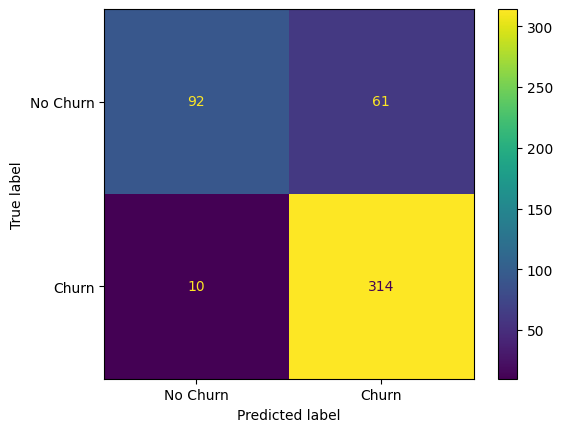

In [212]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels = ['No Churn', 'Churn']).plot()

In [213]:
y_test.shape

(477,)

Only 10 customers out of 477 test customers, we were not able to predict that they will Churn.

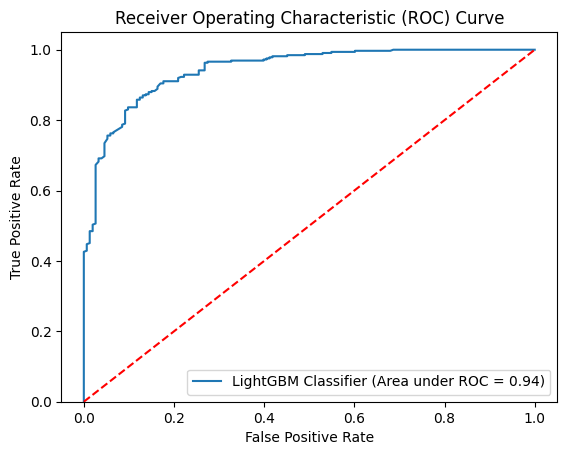

In [214]:
prob = best_model.predict_proba(X_test)
roc_curve_plot(y_test, prob[:, 1], 'LightGBM Classifier')

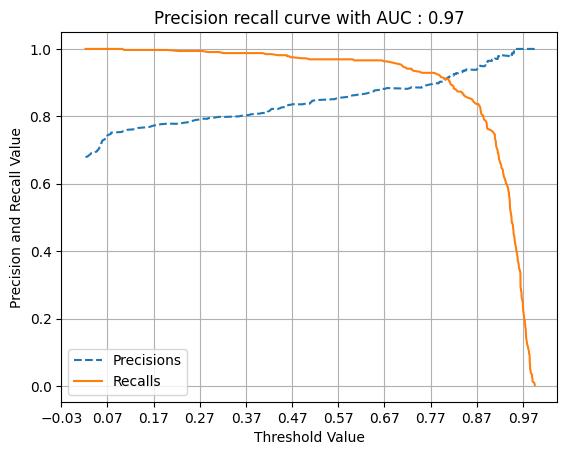

In [215]:
precision_recall_curve_plot(y_test, prob[:, 1])

# Insights & Recommendations
* Churn customers are more in dataset, nearly twice the non churned customers.
* Ages are majorly from 25 to 40. Age 35+ years are more likely to Churn.
* mostly drivers have income 25000 to 100000. From incomes > 75000, churn customers are seen in more percentage
* we see much more churned customers after 2 years (700 days)
* ratio of male to female drivers is 60:40. Both are proportionalely Churning.
* more income & less business value also increases chances of Churn
* quarterly ratings & income is increased recently for Churn customers
* joining designation 1 is more prone to Churn while joining designation 3 retains the drivers more.
* Cities like C20 & C17 have concerning churn rates. Ola should try to retain drivers here.
* High business value drivers have mostly churned which is concerning. Income should be increased proportionately for them.
* While model training, best results for recall were given by LightGBM where we tuned hyperparameters such that we get 97% recall, i.e. Only 10 drivers out of 477 drivers, we were not able to predict that they will Churn.  So, with 97% test accuracy we will be able to predict if driver is about to Churn. We have good enough 84% precision as well. Ola may reach out to these drivers so as to retain them.
* False Positives (driver not churning & predicted Churning) is something Ola can handle but False negatives are critical.

In [244]:
print("please give your suggestions to improve!")

please give your suggestions to improve!
